In [1]:
# Compare result of lora and freeze
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from MlflowHelper import *
from DensePoisson import *
from PlotHelper import *
import mlflow


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319',  '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F', '#EDB120'])



In [12]:
case_name = 'Different PDE'
exp_name = 'lora-fixstep-diffpde'

figname_svd = 'fig_svd_diffpde.png'
figname_loss = 'fig_lora_training_diffpde.png'


# case_name = 'Different forcing'
# exp_name = 'lora-fixstep'

# figname_svd = 'fig_svd_diffforcing.png'
# figname_loss = 'fig_lora_training_diffforcing.png'

In [3]:
# no need to plot solution
# base = PoissonProblem(p=1,exact_D=1)
# D = 1
# x = torch.linspace(0,1,100)
# y = base.u_exact(x,D)

# fig, ax = plt.subplots(figsize=(8, 6),dpi=100)
# ax.plot(x,y, label='base case')

# base.p = 2.0
# y2 = base.u_exact(x,D)
# ax.plot(x,y2, label='different forcing')

# prob2 = PoissonProblem2(p=1,exact_D=1)
# y3 = prob2.u_exact(x,D)
# ax.plot(x,y3, label='different PDE')
# ax.legend()


In [4]:
h = MlflowHelper()
runs = mlflow.search_runs(experiment_names=[exp_name])

In [5]:
res_list = []
data_list = []
total_list = []
step_list = []

# For each run, get the metrics history
for run in runs.iterrows():
    run_id = run[1]['run_id']
    # Get history
    history,_ = h.get_metric_history(run_id)
    
    # Append the 'res' and 'data' histories to the lists
    res_list.append(history['res'])
    # data_list.append(history['data'])
    total_list.append(history['total'])
    step_list.append(history['steps'])

# Add the 'res' and 'data' columns to the DataFrame
runs['res'] = res_list
# runs['data'] = data_list
runs['total'] = total_list
runs['steps'] = step_list

res 6.235417913558194e-06
total 6.235417913558194e-06
D 1.0
res 5.122481888975017e-05
total 5.122481888975017e-05
D 1.0
res 0.004297765903174877
total 0.004297765903174877
D 1.0
res 1.483807045588037e-05
total 1.483807045588037e-05
D 1.0
res 2.1546649804804474e-05
total 2.1546649804804474e-05
D 1.0
res 9.420577043783851e-06
total 9.420577043783851e-06
D 1.0
res 2.884411696868483e-05
total 2.884411696868483e-05
D 1.0
res 4.688648914452642e-06
data 9.191692545984509e-12
total 4.68865800939966e-06
D 1.0
res 8.441638783551753e-06
data 1.6354005927254889e-09
total 8.44327405502554e-06
D 1.0
res 2.045802648353856e-05
data 1.824549192286362e-11
total 2.0458044673432596e-05
D 1.0
res 0.004314980935305357
data 1.1920446496560544e-07
total 0.004315100144594908
D 1.0
res 5.1038561650784686e-05
data 5.897985572156372e-11
total 5.10386198584456e-05
D 1.0
res 2.050548755505588e-05
data 3.429706518787157e-11
total 2.0505522115854546e-05
D 1.0
res 166.6524200439453
data 1.3338180780410767
total 167.98

In [6]:

def create_legend_name(row):
    if row['params.transfer_method'] == 'lora' and 'params.rank' in row:
        return f'LoRA rank {row["params.rank"]}'
    elif row['params.transfer_method'] == 'freeze' and 'params.nlayer_train' in row:
        return f'FT top {row["params.nlayer_train"]}'
    else:
        return 'Unknown'

def compute_parameters(row):
    if row['params.transfer_method'] == 'lora' and 'params.rank' in row:
        return int(row['params.rank']) * 64 * 3
    elif row['params.transfer_method'] == 'freeze' and 'params.nlayer_train' in row:
        return 64 + ( int(row['params.nlayer_train']) - 1) * (64*64 + 64)
    else:
        return None

runs['parameters'] = runs.apply(compute_parameters, axis=1)

runs['legend_name'] = runs.apply(create_legend_name, axis=1)

In [7]:
runs.legend_name
runs.parameters

0      8384
1       384
2      4224
3       768
4       576
5     12544
6       192
7      8384
8     12544
9       576
10     4224
11      384
12      768
13       64
14      192
Name: parameters, dtype: int64

In [8]:
runs['tags.mlflow.runName']

0     freeze_l3_noff_resonly
1      lora_rk2_noff_resonly
2     freeze_l2_noff_resonly
3      lora_rk4_noff_resonly
4      lora_rk3_noff_resonly
5     freeze_l4_noff_resonly
6      lora_rk1_noff_resonly
7             freeze_l3_noff
8             freeze_l4_noff
9              lora_rk3_noff
10            freeze_l2_noff
11             lora_rk2_noff
12             lora_rk4_noff
13            freeze_l1_noff
14             lora_rk1_noff
Name: tags.mlflow.runName, dtype: object

/tmp/ipykernel_1610587/2259467159.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_to_plot.sort_values('tags.mlflow.runName', inplace=True)


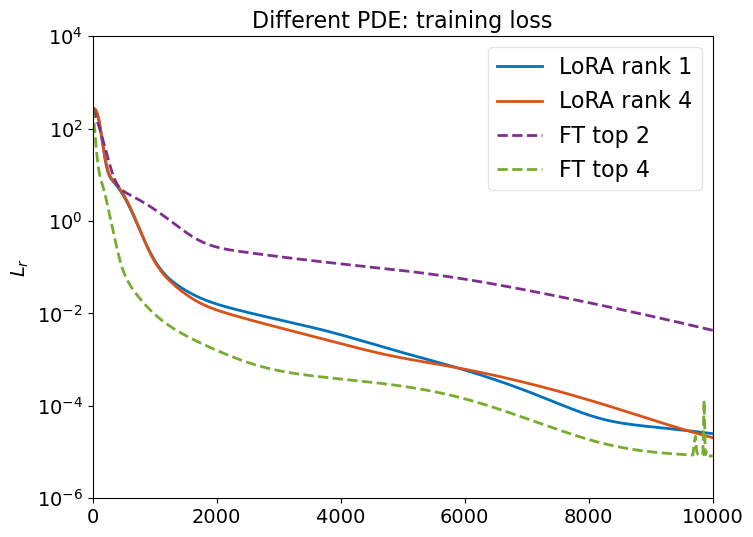

In [9]:
import pandas as pd
import numpy as np
plt.rcParams['font.size'] = 14


runs_plot = ['lora_rk1_noff', 'lora_rk4_noff','freeze_l2_noff','freeze_l4_noff']
window_size = 1
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F'])

# Filter the DataFrame to include only the runs you want to plot
runs_copy = runs.copy()

runs_copy['tags.mlflow.runName'] = pd.Categorical(runs_copy['tags.mlflow.runName'], categories=runs_plot, ordered=True)
runs_to_plot = runs_copy[runs_copy['tags.mlflow.runName'].isin(runs_plot)]
runs_to_plot.sort_values('tags.mlflow.runName', inplace=True)

# Create a new figure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# For each run to plot, plot the 'data' sequence
for _, run in runs_to_plot.iterrows():
    # Get the 'data' sequence and the legend name
    data = pd.Series(run['total'])

    # data = np.log1p(data)
    # data = data.rolling(window_size).mean()
    # data = np.log10(data)

    legend_name = f'{run["legend_name"]}'

    # Determine the line style based on the transfer method
    if run['params.transfer_method'] == 'lora':
        line_style = '-'
    else:
        line_style = '--'

    # Plot the 'data' sequence
    x = np.arange(len(data))*20
    ax.plot(x, data, line_style, label=legend_name)

# Set the y-axis to log scale
# plt.yscale('log')

# Show the legend
lgs = ax.legend(loc='upper right', framealpha=0.5, fontsize=16)
ax.set_ylabel('$L_{r}$')
ax.set_yscale('log')

# ticks = np.log1p([1e-0, 1e-1, 1e-2, 1e-3,])
# plt.yticks(ticks, [f'{tick:.0e}' for tick in np.expm1(ticks)])

# set x lim
ax.set_title(f'{case_name}: training loss', fontsize=16)
ax.set_xlim(0, 10000)
ax.set_ylim(1e-6, 1e4)
fig.set_dpi(100)

for line in ax.lines:
    line.set_linewidth(2)
for legend_line in lgs.get_lines():
    legend_line.set_linewidth(2)

fig.savefig(f'figs/{figname_loss}', bbox_inches='tight')

In [13]:

base = 'lora-fixstep:p1D1_noff'
base_model, _ = load_model(name_str = base)

transfer = f'{exp_name}:freeze_l4_noff'
target_model, _ = load_model(name_str = transfer)

layer_name = 'hidden_layers.1.weight'

s1,s2,s_diff = output_svd(base_model, target_model, layer_name)


net loaded from /home/ziruz16/adjointpinn/mlruns/690849876767752235/c724c616dacf45d5aafe86f56207404e/artifacts/net.pth
net loaded from /home/ziruz16/adjointpinn/mlruns/690849876767752235/51c7e5ad98304b1e8fbc5a98f7d6a70b/artifacts/net.pth


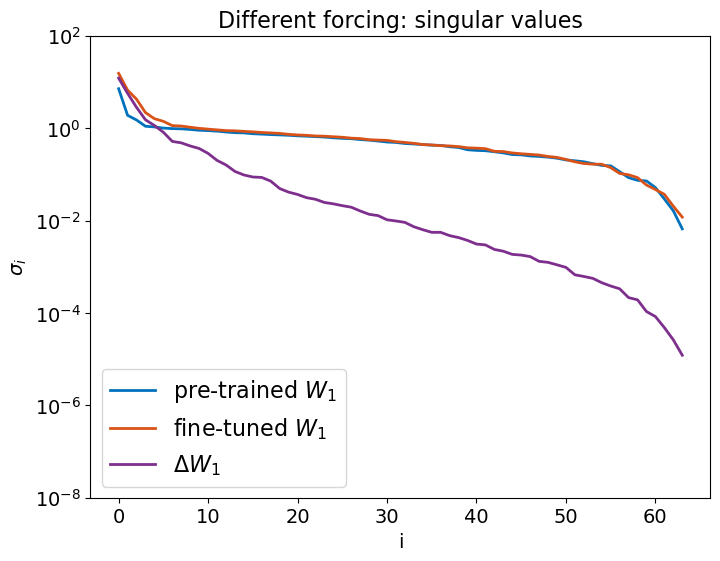

In [14]:

fig, ax = plot_svd(s1, s2, s_diff, 'pre-trained $W_1$', 'fine-tuned $W_1$', '$\Delta W_1$')
fig.set_dpi(100)
ax.set_xlabel('i')
ax.set_ylabel('$\sigma_i$')
lgs = ax.legend(fontsize=16)
ax.set_title(f'{case_name}: singular values', fontsize=16)
ax.set_ylim(1e-8, 100)
# ax.set_xlim(0,63)
for line in ax.lines:
    line.set_linewidth(2)
for legend_line in lgs.get_lines():
    legend_line.set_linewidth(2)


fig.savefig(f'figs/{figname_svd}', bbox_inches='tight')